Estudiantes: Julio César Castro Ortiz y Luz Clara Mora Salazar

Análisis del problema

Utilizando redes adversaria cree nuevas imagenes de perros utilizando el siguiente dataset



In [1]:
import tensorflow as tf
from tensorflow.keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
import imageio
from IPython.display import HTML
from tqdm import tqdm
import time
import sys
import os
from PIL import Image
from Diff_Augment import DiffAugment

In [13]:
!curl -O https://gitlab.com/ejimenez/dogs/-/raw/main/all-dogs.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0  739M    0 3898k    0     0  1279k      0  0:09:51  0:00:03  0:09:48 1279k
  1  739M    1 12.8M    0     0  3253k      0  0:03:52  0:00:04  0:03:48 3254k
  3  739M    3 23.8M    0     0  4841k      0  0:02:36  0:00:05  0:02:31 6078k
  4  739M    4 34.0M    0     0  5767k      0  0:02:11  0:00:06  0:02:05 7589k
  6  739M    6 45.1M    0     0  6553k      0  0:01:55  0:00:07  0:01:48  9.9M
  7  739M    7 56.2M    0     0  7160k      0  0:01:45  0:00:08  0:01:37 10.4M
  9  739M    9 68.0M    0     0  7698k      0  0:01

In [15]:
import zipfile

# Ruta al archivo zip
zip_path = "all-dogs.zip"
# Ruta al directorio donde quieres descomprimir el archivo
extract_path = "all-dogs"
# Descomprimir el archivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Archivo descomprimido en: {extract_path}")


Archivo descomprimido en: all-dogs


Found 20579 files belonging to 1 classes.


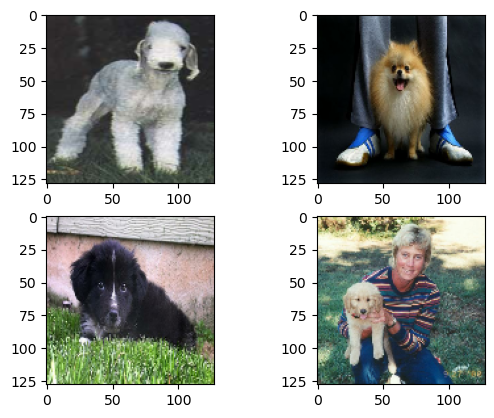

In [2]:
tf.keras.utils.set_random_seed(7)
batch_size = 16
path = "./all-dogs/all-dogs"
dataset = preprocessing.image_dataset_from_directory(
    path, label_mode=None, image_size=(128, 128), batch_size=batch_size
)
dataset = dataset.map(lambda x: (x - 127.5) / 127.5)

trained_models_folder = "./aux_train/"
generated_images_folder = "./aux_train_128/"

for batch in dataset:
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(((batch.numpy() + 1) / 2)[i])  # get in the range [0, 1] for visualizing
    break
plt.show()

Generador

In [3]:
latent_dim = 100

generator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(8 * 8 * 512),
        tf.keras.layers.Reshape((8, 8, 512)),
        tf.keras.layers.Conv2DTranspose(256, kernel_size=(3,3), strides=(2, 2), padding='same',
                                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                                     use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=1.0, scale=0.02),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv2DTranspose(128, kernel_size=(3,3), strides=(2, 2), padding='same',
                                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                                     use_bias=False),
          tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=1.0, scale=0.02),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv2DTranspose(64, kernel_size=(3,3), strides=(2, 2), padding='same',
                                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                                     use_bias=False),
          tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=1.0, scale=0.02),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv2DTranspose(32, kernel_size=(3,3), strides=(2, 2), padding='same',
                                        kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                                        use_bias=False),
          tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001, center=1.0, scale=0.02),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv2D(3,  kernel_size=(3,3), strides=(1, 1), padding='same',
                                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                                     use_bias=False, activation='tanh')
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      1179648   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 256)      1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      29

Discriminador

In [4]:
discriminator = Sequential(
    [
        tf.keras.Input(shape=(128, 128, 3)),
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding="same",
                      kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False),
        tf.keras.layers.LeakyReLU(0.2),

        tf.keras.layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding="same",
                      kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.LeakyReLU(0.2),

        tf.keras.layers.Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding="same",
                            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                            use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.LeakyReLU(0.2),

        tf.keras.layers.Conv2D(512, kernel_size=(5, 5), strides=(2, 2), padding="same",
                            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                            use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.LeakyReLU(0.2),

        tf.keras.layers.Conv2D(1024, kernel_size=(5, 5), strides=(2, 2), padding="same",
                               kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                               use_bias=False),
        tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=0.8, center=1.0, scale=0.02),
        tf.keras.layers.LeakyReLU(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        4800      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       204800    
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)       819200    
                                                     

SALIDA

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


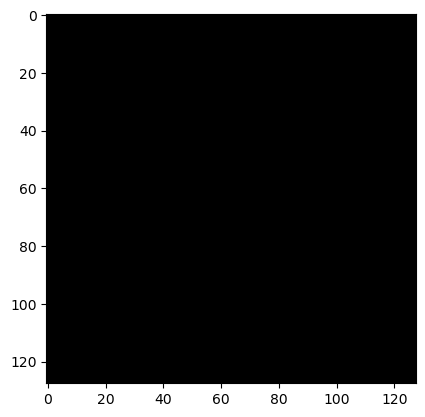

In [5]:
random_noise = tf.random.normal([1, latent_dim])
generated_image = generator(random_noise, training=False)
plt.imshow(generated_image[0])
plt.show()

entrenamiento de DCGAN

In [6]:
decision = discriminator(generated_image)
print('decision', decision)
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    return gen_loss

def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    return disc_loss

generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

decision tf.Tensor([[0.49999988]], shape=(1, 1), dtype=float32)


In [7]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])
    # plt.subplot(1, 2, 1)
    # plt.imshow((images[0].numpy()*255).astype("int32"))
    images = DiffAugment(images, policy='color,translation,cutout')
    # plt.subplot(1, 2, 2)
    # plt.imshow((images[0].numpy()*255).astype("int32"))
    # plt.show()

    with tf.GradientTape() as disc_tape1:
        generated_images = generator(noise, training=True)
        generated_images = DiffAugment(generated_images,policy='color,translation,cutout')

        real_output = discriminator(images, training=True)
        real_targets = tf.ones_like(real_output)
        disc_loss1 = discriminator_loss(real_targets, real_output)

    gradients_disc1 = disc_tape1.gradient(disc_loss1, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_disc1, discriminator.trainable_variables))

    with tf.GradientTape() as disc_tape2:
        fake_output = discriminator(generated_images, training=True)
        fake_targets = tf.zeros_like(fake_output)
        disc_loss2 = discriminator_loss(fake_targets, fake_output)

    gradients_disc2 = disc_tape2.gradient(disc_loss2, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_disc2, discriminator.trainable_variables))

    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        generated_images = DiffAugment(generated_images, policy='color,translation,cutout')
        fake_output = discriminator(generated_images, training=True)
        real_targets = tf.ones_like(fake_output)
        gen_loss = generator_loss(real_targets, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))

    return disc_loss1 + disc_loss2, gen_loss

In [9]:
seed = tf.random.normal([25, latent_dim])
disc_losses = []
gen_losses = []
def train(dataset, epochs):
    generate_and_save_images(generator, 0, seed)
    discriminator.save(trained_models_folder + "Discriminator_epoch_0")
    generator.save(trained_models_folder + "Generator_epoch_0")
    for epoch in range(epochs):
        disc_loss = gen_loss = 0
        print('Currently training on epoch {} (out of {}).'.format(epoch+1, epochs))
        for image_batch in tqdm(dataset):
            losses = train_step(image_batch)
            disc_loss += losses[0]
            gen_loss += losses[1]

        generate_and_save_images(generator, epoch+1, seed)
        gen_losses.append(gen_loss.numpy())
        disc_losses.append(disc_loss.numpy())

        if epoch % 100 == 0:
            discriminator.save(trained_models_folder + "Discriminator_epoch_%d" % epoch)
            generator.save(trained_models_folder + "Generator_epoch_%d" % epoch)

    generate_and_save_images(generator, epochs, seed)
    discriminator.save(trained_models_folder + "Discriminator_epoch_%d" % epochs)
    generator.save(trained_models_folder + "Generator_epoch_%d" % epochs)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os

def generate_and_save_images(model, epoch, seed, dim=(5, 5), figsize=(5, 5)):
    # Generar imágenes a partir del modelo utilizando la semilla
    generated_images = model(seed)
    generated_images *= 255  # Escalar a valores de imagen
    generated_images = generated_images.numpy()  # Convertir a numpy array

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

    # Asegurarse de que la carpeta de destino exista
    if not os.path.exists(generated_images_folder):
        os.makedirs(generated_images_folder)

    # Guardar la imagen generada
    plt.savefig(os.path.join(generated_images_folder, 'generated_image_epoch_%d.png' % epoch))
    plt.close()

In [11]:
train(dataset, 30)

INFO:tensorflow:Assets written to: ./aux_train/Discriminator_epoch_0\assets


INFO:tensorflow:Assets written to: ./aux_train/Discriminator_epoch_0\assets


INFO:tensorflow:Assets written to: ./aux_train/Generator_epoch_0\assets


INFO:tensorflow:Assets written to: ./aux_train/Generator_epoch_0\assets


Currently training on epoch 1 (out of 30).


100%|██████████| 1287/1287 [03:34<00:00,  6.00it/s]


INFO:tensorflow:Assets written to: ./aux_train/Discriminator_epoch_0\assets


INFO:tensorflow:Assets written to: ./aux_train/Discriminator_epoch_0\assets


INFO:tensorflow:Assets written to: ./aux_train/Generator_epoch_0\assets


INFO:tensorflow:Assets written to: ./aux_train/Generator_epoch_0\assets


Currently training on epoch 2 (out of 30).


100%|██████████| 1287/1287 [03:23<00:00,  6.34it/s]


Currently training on epoch 3 (out of 30).


100%|██████████| 1287/1287 [03:22<00:00,  6.36it/s]


Currently training on epoch 4 (out of 30).


100%|██████████| 1287/1287 [03:21<00:00,  6.39it/s]


Currently training on epoch 5 (out of 30).


100%|██████████| 1287/1287 [03:21<00:00,  6.37it/s]


Currently training on epoch 6 (out of 30).


100%|██████████| 1287/1287 [03:22<00:00,  6.37it/s]


Currently training on epoch 7 (out of 30).


100%|██████████| 1287/1287 [03:22<00:00,  6.36it/s]


Currently training on epoch 8 (out of 30).


100%|██████████| 1287/1287 [03:22<00:00,  6.36it/s]


Currently training on epoch 9 (out of 30).


100%|██████████| 1287/1287 [03:22<00:00,  6.36it/s]


Currently training on epoch 10 (out of 30).


100%|██████████| 1287/1287 [03:21<00:00,  6.39it/s]


Currently training on epoch 11 (out of 30).


100%|██████████| 1287/1287 [03:21<00:00,  6.40it/s]


Currently training on epoch 12 (out of 30).


100%|██████████| 1287/1287 [03:21<00:00,  6.38it/s]


Currently training on epoch 13 (out of 30).


100%|██████████| 1287/1287 [03:21<00:00,  6.39it/s]


Currently training on epoch 14 (out of 30).


100%|██████████| 1287/1287 [03:21<00:00,  6.40it/s]


Currently training on epoch 15 (out of 30).


100%|██████████| 1287/1287 [03:21<00:00,  6.39it/s]


Currently training on epoch 16 (out of 30).


100%|██████████| 1287/1287 [03:20<00:00,  6.42it/s]


Currently training on epoch 17 (out of 30).


100%|██████████| 1287/1287 [03:19<00:00,  6.45it/s]


Currently training on epoch 18 (out of 30).


100%|██████████| 1287/1287 [03:19<00:00,  6.45it/s]


Currently training on epoch 19 (out of 30).


100%|██████████| 1287/1287 [03:20<00:00,  6.43it/s]


Currently training on epoch 20 (out of 30).


100%|██████████| 1287/1287 [03:21<00:00,  6.39it/s]


Currently training on epoch 21 (out of 30).


100%|██████████| 1287/1287 [03:22<00:00,  6.34it/s]


Currently training on epoch 22 (out of 30).


100%|██████████| 1287/1287 [03:21<00:00,  6.39it/s]


Currently training on epoch 23 (out of 30).


100%|██████████| 1287/1287 [03:21<00:00,  6.38it/s]


Currently training on epoch 24 (out of 30).


100%|██████████| 1287/1287 [03:21<00:00,  6.37it/s]


Currently training on epoch 25 (out of 30).


100%|██████████| 1287/1287 [03:22<00:00,  6.37it/s]


Currently training on epoch 26 (out of 30).


100%|██████████| 1287/1287 [03:22<00:00,  6.36it/s]


Currently training on epoch 27 (out of 30).


100%|██████████| 1287/1287 [03:22<00:00,  6.36it/s]


Currently training on epoch 28 (out of 30).


100%|██████████| 1287/1287 [03:21<00:00,  6.39it/s]


Currently training on epoch 29 (out of 30).


100%|██████████| 1287/1287 [03:22<00:00,  6.37it/s]


Currently training on epoch 30 (out of 30).


100%|██████████| 1287/1287 [03:21<00:00,  6.37it/s]


INFO:tensorflow:Assets written to: ./aux_train/Discriminator_epoch_30\assets


INFO:tensorflow:Assets written to: ./aux_train/Discriminator_epoch_30\assets


INFO:tensorflow:Assets written to: ./aux_train/Generator_epoch_30\assets


INFO:tensorflow:Assets written to: ./aux_train/Generator_epoch_30\assets


Resultados

In [13]:
# Generate image paths for epochs
image_paths = [f"./aux_train_128/generated_image_epoch_{i}.png" for i in range(31)]

# Create a list to store images
images = []

# Read each image and append to the list
for filename in image_paths:
    images.append(imageio.v3.imread(filename))

# Save images as a GIF
imageio.mimsave("output.gif", images)

# Embed the GIF using HTML
HTML('<img src="output.gif">')
#Yo can see de gif in the content file

Conclusiones

Tanto el generador como el discriminador van mejorando simultáneamente hasta que llega un punto que para nosotros, los humanos, las imágenes creadas por el generador nos parecen tan realistas que no podemos distinguirlas de imágenes reales.

La GAN generó resultados más o menos parecidos en color y silueta a un Perro, ya se observan rasgos que parecen rostros de perros aunque puede ser capaz de mejorar mucho más, con 500  epoch, lo cual no fue posible poner aprueba dado la falta de una gpu que lo soporte. Cada 10 epoch son aprox 30 minutos 